# Python for Linguists module 1.4

Welcome to module 1.4. In this module, we will start calculating statistics using real corpus. 

Let's first refresh your memory on ngrams and probabilities by completing the following quiz:

## Pre-module quiz

Given the sequence 'aabbdab', what is *P*(b|a)?

A. 1/2

B. 1/3

C. 1

D. 0

The correct answer is B. 

## Importing packages

In [61]:
#For tokenization of a sentence
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English() 
tokenizer = nlp.Defaults.create_tokenizer(nlp)

str

## Processing the corpora

We will be using the Shakespeare corpus. The relative path to the corpus file is ../../corpora/shakespeare (.. indicates the parent directory). 
Let's first load the corpus by using the open function:

In [66]:
f=open('../../corpora/Shakespeare','r')

We declared the variable f to open the Shakespeare file. Open takes 2 arguments, the path to the file that we want to open and a string that represents the kinds of permission or operation we want to do on the file. Here 'r' refers to the permission of 'read-only'. 

Let's first import spac for tokenization:

In [ ]:
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English() 
tokenizer = nlp.Defaults.create_tokenizer(nlp)

Let's write a for loop to process each line of the file and store the processed lines as tokenized word lists into another variable

In [67]:
f_processed=[] # a list to store the processed lines
for line in f:
    #for each line, we do:
    #1. remove control characters like \t \r \n
    line=line.strip()
    #2. skip the empty lines
    if line=='':
        continue
    else: 
        #3. tokenize the sentence into word list:
        tokens =[str(tok) for tok in tokenizer(line)]# tokens are now a list of words for the current line
        f_processed.append(tokens)

## Counting Vocabulary

Now let's loop over the word lists in f_processed to create a vocabulary dictionary:

In [69]:
vocab={}# create a vocabulary dictionary where key is the word and value is the count
for line in f_processed:
    for word in line:
        if word in vocab:
            vocab[word]+=1 # update the count for an existing word
        else:
            vocab[word]=1 # initilize the count for a new word


### Practice quiz 1:
What is the count of the word 'book' in the corpus?


In [71]:
vocab['book']

101

## Caluating Type-token ratio

Let's calculate type count first:

In [73]:
type_count=len(vocab.keys())
print (type_count)

32951


Let's caculate token count:

In [75]:
# Let's create a loop to aggregate the token counts in the vocabulary:
token_count=0
for word in vocab:
    token_count+=vocab[word]
print (token_count)


1133110


In [77]:
#Let's calculate the type-token ratio:
ttr=type_count/token_count
print (ttr)

0.029080142263328362


Alternatively, we could wrap the calculation up into a function that takes in vocab dictionary and outputs the ttr

In [79]:
def ttr_cal(vocab):
    type_count=len(vocab.keys())
    token_count=0
    for word in vocab:
        token_count+=vocab[word]
    ttr=type_count/token_count
    return ttr

In [80]:
print (ttr_cal(vocab))

0.029080142263328362


## Plotting a frequency distribution

Let's first import matplotlib for plotting

In [92]:
import matplotlib.pyplot as plt

Then we can sort the words to get the top-100 frequent words

In [115]:
topn=100
vocab_sorted=sorted(vocab.items(),key=lambda x: x[1],reverse=True)[:topn]


loop through the sorted vocabulary to get words and counts for plotting the graphs


In [ ]:
words=[]
counts=[]
for w_c in vocab_sorted:
    w=w_c[0]
    words.append(w)
    count=w_c[1]
    counts.append(count)


We could now plot a histogram using the words and counts

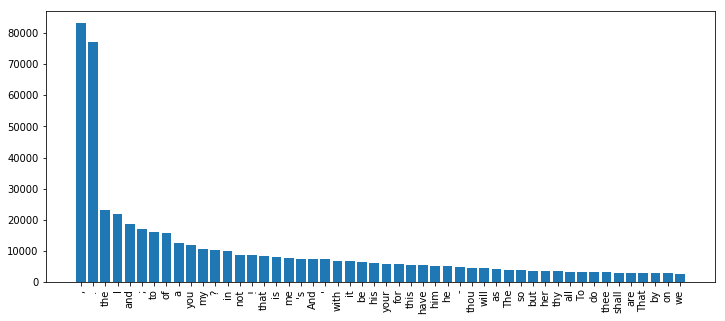

In [114]:
plt.figure(figsize=(12,5)) #figure size
plt.bar(words,counts) #plot the historgram
plt.xticks(rotation=90) # rotate the x label
plt.show()

### Practice quiz 2:
Try changing topn and observe what are the properties of the top-frequent words?


## Counting bigrams

A computer program is usually divided into many *instructions*, which tell the computer what operations should run. For example, run the cell below: 

In [3]:
print('This is an instruction')
print('This is another instruction')

This is an instruction
This is another instruction


As you can see, in Python, each line corresponds to an instruction. If we need, we can break a instruction in multiple lines, but this works only on special cases. For example, if you run the cell below, you will see that

In [4]:
print(
    'A multiline instruction'
)

A multiline instruction


Is a valid instruction. If you run the cell below, instead, you will gen an **`Error`**:

In [5]:
2 +
2

SyntaxError: invalid syntax (<ipython-input-5-61f4b0ef3787>, line 1)

This happens because Python does not know how to read the code in the cell, so it will *raise* a an error and try to display an informative message about what is happening.

As a rule of thumb, statements inside parentheses can be split on multiple lines, in order to improve the readability of the code. However, until you are more confident with the language, we advise you to write an instruction per line.

Please note that when you encounter errors, you should **always** read the error type and message to understand what is happening; however, we will delve into this topic later.

We will start by using Python as a calculator. In Python, numbers support the basic mathematical operations, as `+`, `-`, `*, /`.

For example, we can sum two numbers by writing:

In [ ]:
134 + 25

And we can multiply them by writing:

In [ ]:
13.4 * 4

However, Python supports more complex operations as well, such as the power. For example, $2^3$ can be written as:

In [ ]:
2 ** 3 

We can group operations using parentheses:

In [6]:
(2 ** 3) / 3

2.6666666666666665

## Variables

While playing with a calculator is surely amusing, if we could only do mathematical operations in Python, it would be obviously quite limited. For example, what if we wanted to store the result of an operations, to reuse it again later?

For this reason, virtually all programming languages offer the possibility of storing data in  **variables**. This way, we can store a datum in the computer's memory, and reuse it later, e.g. to form more complex expressions, to pass it to external programs, and so on.

The syntax for assigning variables is

`var_name = value`

For example, if we write and run:

In [7]:
a = 5

We saved the value `5` in the variable `a`. To see the value stored in a variable, we can simply write its name in a cell, e.g.:

In [8]:
a

5

Let's play with some variables! Can you guess the results of the cells below before running them?

In [9]:
a = 5 
b = 2 

In [10]:
a ** b

25

In [11]:
(a + b) / 3

2.3333333333333335

In [12]:
(b * 2) / a - 3

-2.2

In [11]:
string1 = 'hello'
string2 = 'world'
print(string1 + ' ' + string2)

hello world


You can also **update** the content of a variable:

In [13]:
d = a + 3
d

8

In [14]:
a = 1
d = a + 3
d

4

## Comments

Sometimes, when we write code, you may want to describe what a line does, in order to help the future you to understand what that code means. This is achieved using **comments**, special instructions which are *ignored* by Python when you run the code.

In particular, 
- Everything written after a `#` is ignored **until the end of the line**
- Everything written between **triple quotes** (`'''` or `"""`) is ignored.

For example, if we write:

In [15]:
# 2 + 3

Nothing happens! Other examples of comments are:

In [16]:
3 + 2  # this is a comment

5

In [17]:
""" This is 
another comment
"""

' This is \nanother comment\n'

However, these comments are **not valid**:

In [2]:
3 + 2 # this is
a broken comment

SyntaxError: invalid syntax (<ipython-input-2-f506ed4d4dba>, line 2)

In [3]:
3 + 2 """ This comment style work only on non-code lines """

SyntaxError: invalid syntax (<ipython-input-3-75ac46bdd079>, line 1)

In [4]:
3 + """ For example, we can't split a code line like this """ 2

SyntaxError: invalid syntax (<ipython-input-4-aebdf69d22f0>, line 1)

## Errors

So now we have seen what happens when we write bad code: Python refuses to run it and returns an **`Error`**. However, one can (and will) make many, many kinds of errors while writing code, and it's always important to understand them to fix and, possibly, do not repeat them.

For example, the expressions we've seen when talking about variables work because the variables `a`, `b`, and `d` have been previously created. Look what happens if we try to use a variable which has never been assigned:

In [5]:
c + 5

NameError: name 'c' is not defined

Now this error is different from the ones we encountered before. If we read the messages, in fact, the previous errors were `SyntaxError`s, i.e. errors related to the syntax of the code we wrote; now the error is a `NameError`, i.e. Python is telling us that we're referencing the name of a variable that does not exist.

When you encounter an error, you should **always** read the error type and message to know what you're doing wrong. Messages are usually informative and [will help you to solve the problem](https://geekandpoke.typepad.com/geekandpoke/2009/06/the-art-of-bugfixing-chapter-1.html).

There are two kinds of errors:
- `Error` and `Exception` are serious errors that will make your program stop and crash (in other words, bugs).
- `Warnings` are errors that *won't* make your program crash. However, you should always read the warning messages, because they may point to potential errors in your code.

# Built-in data types and functions

## Built-in functions

Python offers a set of built-in functions to perform some basic operations. We have already encountered the simplest of them all: the `print` instruction, which allowed us to write some text below the code cells.

Functions are defined this way:

```
function_name(argument_1, argument_2, ... )
```

For example, `print()` accepts some text as argument and prints it out in the browser (on on a console). Let's see again how it works:

In [29]:
print("Nothing will come of nothing.")

Nothing will come of nothing.


`print` will actually try to, um, print everything you pass to it. For example:

In [30]:
print(3)
print(3 ** 2)
print(a - b ** 7)

3
9
-268435464


Some functions also may **return** a value and/or accept more arguments.

Please note that when we run the cells below, a the red label `Out [xx]` appears below the result of our computation, while when we `print()` something is does not happen. This is because the functions below (can you guess what they're doing?) *return* a value, while `print()` merely shows something to the screen.

For example:

In [26]:
abs(-3)

3

In [27]:
pow(2,3)

8

You can use the return value of a function as you wish. For example, you can store it in a variable, you can use it in another computation, and so on.

In [7]:
a = pow(-2,3)
print(a)
b = abs(a) * 2
print(b)

-8
16


## Types

The built-in function `type()` tells us what is the **type** of something. For example, 

In [8]:
type(2)

int

Do you remember the variables we defined above? Let's check their types:

In [9]:
print(a)
type(a)

-8


int

In [13]:
print(string1)
type(string1)

hello


str

The **type** is a property which tells Python (or, in general, any programming language) how to deal with the object we are giving him, and which operations we can perform on it.


Now, `a` is an **`integer`**, i.e. a number. Hence, Python knows that it can sum, multiply, and divide it. `string1`, instead, is a **string**, i.e. a textual variable. While it's obvious that we can't "divide" a string, we can perform other kinds of operations on it, e.g.:

In [16]:
print(string1)
print(string1[0])   # get the first character of 'hello'
string1 + string2

hello
h


'helloworld'

We will see later what this operations mean; by know, you can try to guess what we're doing here. 

Python offers this built-in types, which we will describe in detail below:

- Numbers, i.e. integers, floating point numbers (i.e. non-integers), and complex numbers.
- Strings, i.e. text
- Booleans, i.e. the truth values `True` and `False` of the [Boolean Algebra](https://en.wikipedia.org/wiki/Boolean_algebra) 

You don't need to know much else about types for now. However, we will sometime use `type` to see how Python handles data. 

## Numbers

We already encountered numbers. Now, we'll see some operations that Python offers to handle them.

In [18]:
print(1 + 2)    # sum
print(3 - 7)    # subtraction
print(2 * 3)    # multiplication
print(5 / 6)    # division
print(2 ** 3)   # power

3
-4
6
0.8333333333333334
8


Python offers the several built-int mathematical functions (any many more):

In [27]:
print(pow(2,3))             # power
print(abs(-3))              # absolute value
print(round(987.654321,3))  # rounding to the nth decimal
print(round(22/7,2))        # does this ring any bell?
print(max(10,1000))         # maximum value between two numbers
print(min(-1000,-10))       # minumum value between two numbers

8
3
987.654
3.14
1000
-1000


Can you guess the difference between this two divisions?

In [31]:
7/2

3.5

In [33]:
7//2

3

As we know, computers store information using bits. For this reason, numbers are stored using the [floating point representation](https://en.wikipedia.org/wiki/Floating-point_arithmetic). You don't need to know the details of how does it work; however, you should be aware that `1` and `1.0` are two different things in Python.

In fact, let's see their types:

In [34]:
print(type(1))
print(type(1.0))

<class 'int'>
<class 'float'>


Now that you know that, what is the difference between `/` and `//`?

## Booleans

The boolean values `True` and `False` are the *truth values* associated to a statement; for example, `Shakespeare was an English poet` is a true statement, and `Claudius is a character in Romeo and Juliet` is a false statement.

Unfortunately, Python can't understand natural language statements. However, boolean algebra is vastly used when programming; for example, we can compare numerical values using the classic comparison operations:

+ greater `<` and lesser `>`
+ greater or equal `<=` and lesser or equal `>=`
+ equal `==` and not equal `!=`

The results of comparison operations are of type **boolean**.

In [35]:
2 < 3

True

In [36]:
a = 4
b = 3
c = 3

print(a < b)
print(b < c)
print(b <= c)

print(a == b)
print(a != b)

False
False
True
False
True


In [37]:
d = (a == b)
print(type(d))

<class 'bool'>


## Strings

`string` is the fancy name used by programmers for sequences of characters, i.e. for *textual* variables.

As we already encountered them, you should already know how to create a string: you just have to place the text between single (`'`) or double (`''`) quotation marks.

In [41]:
s1 = '' # empty string
s2 = "hello"
s3 = 'mum'
s4 = 'hello mum'
s5 = '2345'

We can perform a wide range of operations over strings. For example, we can get their length:

In [42]:
print(len(s1))
print(len(s2))

0
5


We can *concatenate* strings using the `+` operator:

In [43]:
print(s2 + s3) # we concatenate s2 and s3
print(s2 + " " + s3)

hellomum
hello mum


Notice that `s2 + " " + s3` is equal to the string `"hello mum"`:

In [44]:
(s2 + " " + s3) == s4

True

If needed, we can even *multiply* strings, i.e. *repeat* them:

In [46]:
print(s2 * 3)  # we repeat s2 three times

hellohellohello


### Indexing and slicing

Other common operations over strings are *indexing* and *slicing*. **Indexing** allows us to get the $n$-th element of any sequence of elements, using this syntax:
    
```python
variable[index]
```

returns the $index$-th element of the variable `variable`.

In [47]:
s = 'this is an example'

# indexing (to access a byte in the string)
print(s[0]) # print the first character of the string
print(s[1]) # print the second character of the string

t
h


If you're not familiar with programming, you probably are asking yourself why we getting the *zeroth-*element of our string did not end up in error.

This happens because in Python indices start with zero. This is called **[Zero-based indexing](https://en.wikipedia.org/wiki/Zero-based_numbering)**, and it is a convention used in most programming language for performance reasons. 

This also means that, if a string has five characters, e.g. `hello`, its last element will have index 4:

In [48]:
'hello'[4]

'o'

Let's see other examples:

In [52]:
s = 'Romeo and Juliet'
print(s[0])
print(s[15])

# How to we get the last character of a string without having to 
# count how many character contains manually?

print(s[len(s) - 1])       # we can use len()
print(s[-1])               # or we can use the negative notation

R
t
t
t


As we've seen in this last example, negative indexing tells Python to start looking from the last character:

In [54]:
'hello'[-4]

'e'

If we need more than a character from a string, we can use **slicing**. The syntax is:
```
variable[start_position:end_position]
```
For example, to get the first two character of a string, we write:

In [55]:
'hello'[0:2]

'he'

Please note that *spans* will *not* contain the character denoted by the right index.

Let's see tome other examples:

In [62]:
print(s)
print(s[0:2])
print(s[:2])  # the same as s[0:2]
print(s[5:])  # the same as s[5:len(s) -1]
print(s[1:2])
print(s[-3:]) # we can use negative indexing too!

Romeo and Juliet
Ro
Ro
 and Juliet
o
iet


As you have seen in this example, we can **omit** one of the two indices of the span if we want Python to look up from the beginning (omitting the left index) or to the end (omitting the right index) of the string.

### Built-in string functions

Now we will introduce a new class of functions, i.e. **object methods**. The syntax for this kind of functions is called *dot notation* and works this way:
```python
object.function()
```
This particular syntax tells Python that the function `function()` belongs to `object`. This kind of functions are particular of that kind of object; for example, it would not make sense to do the square root of a string, or to replace all the threes in a number with the dollar symbol. 

For example, we can find specific substrings in a string using `string.find()`:

In [63]:
print(s.find("Juliet"))  
print(s.find("Othello"))

10
-1


`find()` returns the index where the given substring starts, or `-1` if the given substring is not present in the input string.

`replace()` allows us to find a substring and replace it with something new:

In [65]:
d = s.replace("Romeo", "King Lear")

print(d) 
print(s) 

King Lear and Juliet
Romeo and Juliet


Please notice how the string assigned to variable `s` is not modified, and the result of the operation is stored in the new variable `d`.

You should also be aware that `replace` operation will replace _all_ mentions of the given substring:

In [66]:
s = s.replace(" ", "_")
print(s)

Romeo_and_Juliet


In [68]:
# what happens if the requested string does not exist in the input one?
s.replace("Desdemona","Ophelia")

'Romeo_and_Juliet'

Other useful operations on strings are the following:

In [ ]:
x = "This is a nice University"

# convert to upper/lowercase
print(x.upper())
print(x.lower())

# concatenate with a given delimiter
print("-".join(x))
print("*".join(x))

# splits string at delimiter.
# creates a list (see below) with the obtaines substrings
print(x.split("nice"))  
print(x.split(" "))     # delimiter found multiple times.
print(x.split("x"))     # delimiter not found. Creates a list with the entire string as the only element

We usually cannot mix strings and numbers in operations. If we do that, we may obtain something different then expected:

In [74]:
number142 = 142
string142 = '142'

print(number142)
print(string142)

print(type(number142))
print(type(string142))

print(number142 == string142)

142
142
<class 'int'>
<class 'str'>
False


Play with strings in the cell below.

In [ ]:
othello = 'Men should be what they seem'

## Converting between types

In [ ]:
"142" + 4

before this, we need to convert them to the desider data type!

In [ ]:
int("142") + 4

It is important to always remember the data type of our variables.

If not, we could obtain results different than expected...

In [ ]:
a = "3"
b = "4"

print(a + b)
print(int(a) + int(b))

### Lists and Sets

Lists are
positionally ordered collections of arbitrarily typed objects. 

In [ ]:
# a list of three different object types
L=[1,'a',True]
print(L)
# the lenghth of the list
len(L)

we can index, slice, and so on, just as for strings:

In [ ]:
#index
print(L[0])

#slice
print (L[:-1])
#concatenate with another list
print(L+[2,3,4])

Further, lists have no fixed size. That is, they can grow and
shrink on demand, in response to list-specific operations

In [ ]:
L=[1,'a',True]

#append at the end
L.append('b')
print (L)

# delete an item at index 1 and returns the deleted item
print (L.pop(1))
# delete an item at index 0
del L[0]
print (L)
# delete the first matching item by value in a list:
L.remove('b')
print(L) # removes 'b'

#insert: L.insert (position, item): insert an item at position of L
L.insert(0,'a')
print (L)




In [19]:
# sort the list by ascending order
L=[1,4,3]
L.sort()
print (L)
# sort the list by descending order
L.reverse()
print (L)

[1, 3, 4]
[4, 3, 1]


Note: Because lists are mutable, most of the list methods modify the lists directly instead of create a new one. (Compare it with strings) Advanced: nesting and list comprehensions

Sets are unordered collections of unique and immutable objects. 

In [20]:
# create a set:
a={1,'a','b'}
# create a set from a list: will only maintain the unique items
b=set([1,'a','a','b'])
print (a)
print (b)

{1, 'b', 'a'}
{1, 'b', 'a'}


### Dictionaries

Dictionaries are a mutable mapping type that map keys to their associated value.

In [21]:
D = {'food': 'Spam', 'quantity': 4, 'color': 'pink'}
print (D['food']) # Fetch value of key 'food'
D['quantity'] = 1 # assign a new value
D['size']=10 #create a new key by assignment
print (D)

Spam
{'food': 'Spam', 'quantity': 1, 'color': 'pink', 'size': 10}


We will encounter a key error if we fetch a key that does not exist. 

In [22]:
D['shape']

KeyError: 'shape'

We could use .get() method to return a default value

In [ ]:
print(D.get('color')()
print(D.get('shape',0))

Advanced: sorting the keys

### Tuples

Tuples are sequences, like lists, but they are immutable, like strings.

There are some methods specific to tuples: 

In [ ]:
T = (1, 2, 3, 4,2)
print(T.index(4)) # the index of the first matching 4 in the tuple 
print (T.count(2)) # the number of times 2 occurs in the tuple

Because tuples are immutable, we cannot change the tuples (ie. item assignment, appending...) once they are created. 

In [ ]:
T[0]=2 # will give warnings

### Files

File objects are Python code’s main interface to external files on your computer. To create a file object, you call the built-in open function, passing in an external filename and a processing mode as strings. 

In [ ]:
# create a file with 'w' (write) processing mode
f=open('test', 'w')
#write some strings to the file
f.write('hello world\n')
# don't forget to close the file
f.close()

In [ ]:
#Even better, we could use the following without explicitly closing the file
with open('test','w') as f:
    f.write('hellow world\n')

## Statements and Loops

In Python
we normally code one statement per line and indent all the statements in a nested block
the same amount

Assignment Statememt

In [ ]:
# basic assignment
count = 0
print (count)

# augmented assignemnt
count+=1 #equals to count=count+1
print (count)

# sequence assignment
a, b, c, d = 'spam' 
print (a)

#multiple target assignment
spam=ham='spam'
print (spam)
print (ham)

In Python, you can use an expression as a statement, too—that is, on a line by itself, but they do not return any values.

In [ ]:
#for example, in-place list methods returns None
L=[1,2,3]
a=L.sort()
print (a)

# compare with sorted() function
b=sorted(L)
print (b)

### IF statements

In simple terms, the Python if statement selects actions to perform. 

It
takes the form of an if test, followed by one or more optional elif (“else if”) tests and
a final optional else block. The tests and the else part each have an associated block
of nested statements, indented under a header line.

In [ ]:
#check if x is negative, 0 or positive, and print accordingly
x=1
if x<0:
    print ('negative')
elif x==0:
    print ('0')
else:
    print ('positive')

### FOR and WHILE loops

For and While loops are statements that repeat an action over

The first of these, the while statement, provides a way to code general loops. 

In [ ]:
# a loop that strip the last letter of a string one by one
x = 'spam'
while x: # While x is not empty
    print(x)
    x = x[1:] # Strip first character off x

We could add 'break', 'continue' statements to the loop:

In [ ]:
x = 'spam'
while x: # While x is not empty
    print(x)
    x = x[1:] # Strip first character off x
    if len(x)<2:
        break # stop when the length of the string is shorter than 2
    else:
        continue # else, continue to the next iteration in the loop

The second, the for statement, is designed for stepping through the items in a sequence
object and running a block of code for each. The built-in range function produces a series of successively higher integers, which can be used as indexes in a for loop

In [ ]:
# Let's write the previous while method into the for loop:
x='spam'
for i in range(len(x)): #we need to specify the number of itrations in the loop. 
    print (x)
    x=x[1:]
    if len(x)<2:
        break
    else:
        continue

## Functions

## How to import Modules

Some useful packages for NLP:

+ NLTK
+ numpy
+ gensim (?)

## How to install Python and using a Console

## Further Readings

+ [Learning Python](http://shop.oreilly.com/product/0636920028154.do)
+ [Python Cookbook](https://www.oreilly.com/library/view/python-cookbook-3rd/9781449357337/)
+ [Natural Language Processing with Python: Analyzing Text with the Natural Language Toolkit](http://shop.oreilly.com/product/9780596516499.do) (https://www.nltk.org/book/)
+ maybe links to online Python courses?
+ ...?